# Identify binaries on HST imaging data

### Rationale

Workbook 2 predicts many stars, that the ELT could use for wavefront sensing, to be binary star systems with angular separation and brightness ratios that may be problematic for ELT operations.

The eventual goal is to use Gaia data to identify these problematic targets, but it is a priori unclear how to optimally use Gaia for this task, and which binaries it is sensitive to. 

In this workbook we use imaging data from the Hubble Legacy Archive to identify stars that appear to be binaries. Even though HST has a primary mirror of only 2.4m diameter, its stable PSF allows us to identify deviations from a "standard" light profile, especially for the relatively bright stars that ELT would use.

In Notebook 4, we use the binaries that are identified using HST data to tune a model based on Gaia data to flag problematic source whenever HST imaging data is not available (i.e. most of the sky).

### Obtaining and Cleaning the data
We run an SQL query on the HLA and select sources in the CANDELS fields with magnitude < 22 in the F160W filter. Specifically, we target PropIDs: 12063, 12440, 12443, 12061, 12064. We perform additional cleaning to discard clearly extended objects.

By combining (adding) cutout of clean stars in a pairwise fashion without subsampling, we obtain artificial binary stars with known properties (angular separation and brightness ratios). 

### Model used
We use a Convolutional Neural Network (CNN) that we train on the two classes: single stars and "known" binary systems. The network consists of three convolutional layers with MaxPooling, and two fully connected layers. 

We augment the training sample by flipping the input images both vertically and horizontally, and performing shifts of -1, 0, or 1 pixel in both vertical and horizontal direction. After augmentation, we do not overfit the model to the training data. 

### Performance and next steps
For a threshold that allows 5% false positive detections, we select more than 80% of the true positives. The AUC is 0.95. 

The PSF depends on the position on the detector chips. For increased performance, this position (for instance X, Y in focal plane) could be added as input the the NN (for instance in the FC layers).

In [1]:
# Loading modules
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import random
from astropy.io import fits
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import requests
from io import BytesIO
from astropy.stats import sigma_clipped_stats
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from pyvo.dal import tap
HST_TAP_CAT = "http://vao.stsci.edu/HSCTAP/tapservice.aspx"
tapcathst = tap.TAPService(HST_TAP_CAT)


def query_hla_candels():
    """Query Hubble Legacy Archive database for catalogue data, CANDELS fields"""  
    query="""SELECT * FROM dbo.DetailedCatalog
    WHERE ((PropID ='12063') OR (PropID ='12440') OR (PropID ='12443') OR (PropID ='12061') OR (PropID ='12064'))
    AND Filter = 'F160W'
    AND MagAuto < 22."""
    print(query)
    res = tapcathst.run_sync(query)
    df_HLA = res.to_table().to_pandas()
    return df_HLA

def query_hla(nobjects):
    """Query Hubble Legacy Archive database for catalogue data"""
    query=f"""SELECT TOP {nobjects} * FROM dbo.DetailedCatalog
    WHERE Filter = 'F160W'
    AND MagAuto < 22."""
    print(query)
    res = tapcathst.run_sync(query)
    df_HLA = res.to_table().to_pandas()
    return df_HLA

def getimage(x,y,image):
    """Retrieve corresponding image, based on x, y coordinates and image name"""
    thisurl = "https://hla.stsci.edu/cgi-bin/fitscut.cgi?red="+image+"&amp;size=99&amp;x="+str(x)+"&amp;y="+str(y)+"&amp;format=fits&amp;Badpix=True"
    r = requests.get(thisurl)
    hdu = fits.open(BytesIO(r.content))
    return hdu

def get_background(im):
    """Measure rough background in image from the edges"""
    edges=[im[0,:], im[:,-1], im[-1,:], im[:,0]]
    background = sigma_clipped_stats(edges, sigma=3, maxiters=10)[0]
    return background

        Use Sphinx>=1.7 automatically inherits docstring instead. [astropy.extern.six]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.utils.xml.elements]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.voresource]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.vodataservice]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.vosi.vo

        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.tree]
        Use Sphinx>=1.7 automatically inherits docstring instead. [pyvo.io.uws.endpoint]


## Query Hubble Legacy Archive

In [2]:
#Example, to be explored more in Notebook 4
df_hla = query_hla(10000)


SELECT TOP 10000 * FROM dbo.DetailedCatalog
    WHERE Filter = 'F160W'
    AND MagAuto < 22.


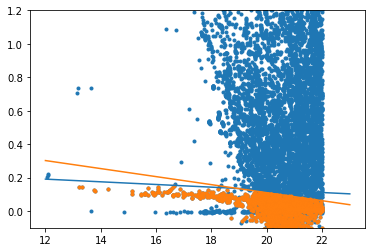

In [3]:
# Select stars based on aperture magnitude and total magnitude, and Kron Radius
X = df_hla.MagAuto
Y = df_hla.MagAper2-df_hla.MagAuto

plt.scatter(X, Y, marker='.')
SELSTAR = (df_hla['KronRadius'] < 0.5) & (Y < 0.175-0.008*(X-14.)) & (Y < 0.110-0.024*(X-20.))
plt.scatter(X[SELSTAR], Y[SELSTAR], marker='.')

A=np.linspace(12,23,10)
plt.plot(A,0.175-0.008*(A-14.))
plt.plot(A,0.110-0.024*(A-20.))

plt.ylim((-0.1,1.2))
df_new = df_hla[SELSTAR]


In [7]:
# Make cutouts
for ipos, (x, y, image) in enumerate(zip(df_new['XImage'], df_new['YImage'], df_new['ImageName'])):
    print(ipos, x, y, image)
    hdu = getimage(x, y, image)
    background = get_background(hdu[0].data)
    hdu[0].data = hdu[0].data-background
    hdu.writeto('./cutouts/df_new_entry_'+str(ipos)+'.fits', overwrite = True)
    break

0 1490.98095703125 980.117004394531 hst_12332_13_wfc3_ir_f160w


In [8]:
#This is after running on CANDELS fields, selecting stars and cross-matching with Gaia
#All postage stamps are in cutouts_HLA_CANDELS_orig
df_new = pd.read_csv('./df_new_HLA_candels.txt', sep=',')

#Based on this cleaned stellar catalogue we made our own binaries by combining the original stars pairwise
#All postage stamps are in cutouts_HLA_CANDELS_binaries
#Their properties are in df_binaries dataframe
df_binaries = pd.read_csv('./df_binaries_HLA_candels.txt', sep=',')


## Training sample

In [9]:
hnewdim = 16 #half the dimension. The images files are 32x32 pixels
def splittraintest(files, singleorbinary):
    """Convert the fits images into RGB jpeg images. 
    Also split the data between Training and Test (Validation) set.
    Cutouts are 32x32 pixels."""
    for i, file in enumerate(files):
        hdul = fits.open(source+file)
        orig = hdul[0].data
        holddim = 0.5*len(orig)
        cutout = orig[int(holddim-hnewdim):int(holddim+hnewdim),int(holddim-hnewdim):int(holddim+hnewdim)]
        cutout = cutout/np.max(cutout)*255. #scale from 0 to 255
        im = Image.fromarray(cutout)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        if i%5 == 0:     #20% in the Test set
            dest = 'Test'
        else:            #80% in the Train set
            dest = 'Train'
        im.save('./CNN_input/'+dest+'/'+singleorbinary+'/'+file.split('.')[0]+'.jpeg')


In [10]:
source = './cutouts_HLA_CANDELS_binaries/'
files = os.listdir(source)
random.shuffle(files)
splittraintest(files,'Binary')
source = './cutouts_HLA_CANDELS_orig/'
files = os.listdir(source)
random.shuffle(files)
splittraintest(files,'Single')

In [11]:
#Augment the training and test sets with flips and integer pixel shifts.
train = ImageDataGenerator(rescale=1/255,horizontal_flip=True,vertical_flip=True,height_shift_range=2,width_shift_range=2) #back on scale from 0 to 1
test = ImageDataGenerator(rescale=1/255,horizontal_flip=True,vertical_flip=True,height_shift_range=2,width_shift_range=2)

train_dataset = train.flow_from_directory("./CNN_input/Train/",
                                          target_size=(32,32),
                                          batch_size = 32,
                                          class_mode = 'binary', classes=['Single','Binary'])
                                         
test_dataset = test.flow_from_directory("./CNN_input/Test/",
                                          target_size=(32,32),
                                          batch_size =32,
                                          class_mode = 'binary', classes=['Single','Binary'])

Found 2509 images belonging to 2 classes.
Found 1222 images belonging to 2 classes.


In [12]:
test_dataset.class_indices

{'Single': 0, 'Binary': 1}

## Model definition and Training

In [13]:
model = tf.keras.models.Sequential([
# Input shape is 32*32, and 3 channels because of jpeg
# First convolution
tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(32, 32, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# Second convolution
tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
tf.keras.layers.Flatten(),
# Two fully connected layers 
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1. Close to 1 is likely binary, close to 0 likely single star.
tf.keras.layers.Dense(1, activation='sigmoid')])
    
    

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [15]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0003),metrics='accuracy')

In [16]:
history = model.fit(train_dataset,
         steps_per_epoch = 40,  #Batches of 32 images
         epochs = 150,
         validation_data = test_dataset
         )

Epoch 1/150
40/40 [==============================] - 4s 79ms/step - loss: 0.6777 - accuracy: 0.5725 - val_loss: 0.6240 - val_accuracy: 0.6596
Epoch 2/150
40/40 [==============================] - 2s 40ms/step - loss: 0.6177 - accuracy: 0.6996 - val_loss: 0.6026 - val_accuracy: 0.7119
Epoch 3/150
40/40 [==============================] - 2s 38ms/step - loss: 0.5805 - accuracy: 0.7403 - val_loss: 0.5703 - val_accuracy: 0.7381
Epoch 4/150
40/40 [==============================] - 2s 38ms/step - loss: 0.5551 - accuracy: 0.7479 - val_loss: 0.5536 - val_accuracy: 0.7267
Epoch 5/150
40/40 [==============================] - 1s 36ms/step - loss: 0.5365 - accuracy: 0.7409 - val_loss: 0.5245 - val_accuracy: 0.7594
Epoch 6/150
40/40 [==============================] - 1s 35ms/step - loss: 0.5403 - accuracy: 0.7569 - val_loss: 0.4963 - val_accuracy: 0.7684
Epoch 7/150
40/40 [==============================] - 2s 50ms/step - loss: 0.5282 - accuracy: 0.7485 - val_loss: 0.4914 - val_accuracy: 0.7733
Epoch 

40/40 [==============================] - 1s 37ms/step - loss: 0.3461 - accuracy: 0.8559 - val_loss: 0.3060 - val_accuracy: 0.8797
Epoch 59/150
40/40 [==============================] - 1s 37ms/step - loss: 0.3248 - accuracy: 0.8697 - val_loss: 0.3434 - val_accuracy: 0.8527
Epoch 60/150
40/40 [==============================] - 1s 36ms/step - loss: 0.3329 - accuracy: 0.8588 - val_loss: 0.3113 - val_accuracy: 0.8732
Epoch 61/150
40/40 [==============================] - 2s 39ms/step - loss: 0.3140 - accuracy: 0.8701 - val_loss: 0.3529 - val_accuracy: 0.8552
Epoch 62/150
40/40 [==============================] - 1s 36ms/step - loss: 0.3562 - accuracy: 0.8591 - val_loss: 0.3715 - val_accuracy: 0.8322
Epoch 63/150
40/40 [==============================] - 1s 36ms/step - loss: 0.3379 - accuracy: 0.8571 - val_loss: 0.3312 - val_accuracy: 0.8666
Epoch 64/150
40/40 [==============================] - 1s 37ms/step - loss: 0.3315 - accuracy: 0.8618 - val_loss: 0.3300 - val_accuracy: 0.8601
Epoch 65/150

40/40 [==============================] - 1s 35ms/step - loss: 0.3063 - accuracy: 0.8700 - val_loss: 0.2787 - val_accuracy: 0.8903
Epoch 116/150
40/40 [==============================] - 2s 39ms/step - loss: 0.2782 - accuracy: 0.8948 - val_loss: 0.3353 - val_accuracy: 0.8535
Epoch 117/150
40/40 [==============================] - 2s 40ms/step - loss: 0.2851 - accuracy: 0.9014 - val_loss: 0.2800 - val_accuracy: 0.8944
Epoch 118/150
40/40 [==============================] - 1s 35ms/step - loss: 0.3192 - accuracy: 0.8761 - val_loss: 0.3098 - val_accuracy: 0.8846
Epoch 119/150
40/40 [==============================] - 1s 36ms/step - loss: 0.2993 - accuracy: 0.8798 - val_loss: 0.2788 - val_accuracy: 0.8903
Epoch 120/150
40/40 [==============================] - 1s 35ms/step - loss: 0.3146 - accuracy: 0.8679 - val_loss: 0.2870 - val_accuracy: 0.8928
Epoch 121/150
40/40 [==============================] - 1s 36ms/step - loss: 0.2786 - accuracy: 0.8918 - val_loss: 0.3317 - val_accuracy: 0.8674
Epoch 

In [17]:
#Save model for later
model.save('cnn_model_binaryclassifier')

INFO:tensorflow:Assets written to: cnn_model_binaryclassifier/assets


## Model evaluation

In [18]:
def plot_loss(history):
    """Check performance"""
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0.1, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

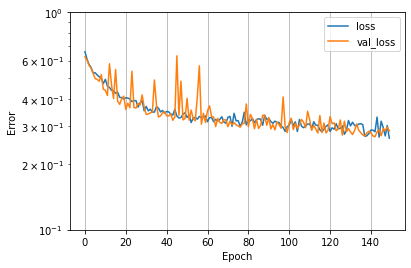

In [19]:
#Loss on training set and validation set are almost identical, indicating small variance.
#Bias is relatively high, but performance is expected to be low for a substantial fraction of the data set; binaries with small separation and/or large brightness ratios.
plot_loss(history)

In [26]:
from tensorflow.keras.preprocessing import image
def predictImage(filename):
    """Can be different image than is part of test and train sets.
    This is not optimised, since it runs on a single image."""
    img1 = image.load_img(filename,target_size=(32,32))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    XNORM = X/255. #From 0 to 1
    val = model.predict(XNORM)
    print(val)
    if val == 1:     
        plt.xlabel("Single",fontsize=30)
    elif val == 0:
        plt.xlabel("Binary",fontsize=30)
    return(val)

./CNN_input/Test/Binary/df_binaries_entry_919.jpeg
[[0.999726]]
919 [[0.999726]]
./CNN_input/Test/Binary/df_binaries_entry_763.jpeg
[[0.99716246]]
763 [[0.99716246]]
./CNN_input/Test/Binary/df_binaries_entry_299.jpeg
[[0.9961264]]
299 [[0.9961264]]
./CNN_input/Test/Binary/df_binaries_entry_108.jpeg
[[0.8789451]]
108 [[0.8789451]]
./CNN_input/Test/Binary/df_binaries_entry_734.jpeg
[[0.9990777]]
734 [[0.9990777]]
./CNN_input/Test/Binary/df_binaries_entry_958.jpeg
[[0.7396964]]
958 [[0.7396964]]
./CNN_input/Test/Binary/df_binaries_entry_372.jpeg
[[0.48275524]]
372 [[0.48275524]]
./CNN_input/Test/Binary/df_binaries_entry_325.jpeg
[[0.06924981]]
325 [[0.06924981]]
./CNN_input/Test/Binary/df_binaries_entry_630.jpeg
[[0.24071279]]
630 [[0.24071279]]
./CNN_input/Test/Binary/df_binaries_entry_562.jpeg
[[0.8085181]]
562 [[0.8085181]]
./CNN_input/Test/Binary/df_binaries_entry_132.jpeg
[[0.7820966]]
132 [[0.7820966]]
./CNN_input/Test/Binary/df_binaries_entry_57.jpeg
[[0.74134266]]
57 [[0.74134266]

[[0.9053784]]
426 [[0.9053784]]
./CNN_input/Test/Binary/df_binaries_entry_830.jpeg
[[0.21254775]]
830 [[0.21254775]]
./CNN_input/Test/Binary/df_binaries_entry_261.jpeg
[[0.9030218]]
261 [[0.9030218]]
./CNN_input/Test/Binary/df_binaries_entry_631.jpeg
[[0.99957955]]
631 [[0.99957955]]
./CNN_input/Test/Binary/df_binaries_entry_373.jpeg
[[0.9984956]]
373 [[0.9984956]]
./CNN_input/Test/Binary/df_binaries_entry_95.jpeg
[[0.99543303]]
95 [[0.99543303]]
./CNN_input/Test/Binary/df_binaries_entry_666.jpeg
[[0.9026105]]
666 [[0.9026105]]
./CNN_input/Test/Binary/df_binaries_entry_365.jpeg
[[0.8652416]]
365 [[0.8652416]]
./CNN_input/Test/Binary/df_binaries_entry_735.jpeg
[[0.29262117]]
735 [[0.29262117]]
./CNN_input/Test/Binary/df_binaries_entry_220.jpeg
[[0.08889472]]
220 [[0.08889472]]
./CNN_input/Test/Binary/df_binaries_entry_670.jpeg
[[0.9731697]]
670 [[0.9731697]]
./CNN_input/Test/Binary/df_binaries_entry_83.jpeg
[[0.73755527]]
83 [[0.73755527]]
./CNN_input/Test/Binary/df_binaries_entry_559.j

[[0.40218067]]
772 [[0.40218067]]
./CNN_input/Test/Binary/df_binaries_entry_267.jpeg
[[0.997826]]
267 [[0.997826]]
./CNN_input/Test/Binary/df_binaries_entry_725.jpeg
[[0.9260392]]
725 [[0.9260392]]
./CNN_input/Test/Binary/df_binaries_entry_230.jpeg
[[0.98761344]]
230 [[0.98761344]]
./CNN_input/Test/Binary/df_binaries_entry_699.jpeg
[[0.9998941]]
699 [[0.9998941]]
./CNN_input/Test/Binary/df_binaries_entry_85.jpeg
[[0.98796666]]
85 [[0.98796666]]
./CNN_input/Test/Binary/df_binaries_entry_676.jpeg
[[0.999232]]
676 [[0.999232]]
./CNN_input/Test/Binary/df_binaries_entry_949.jpeg
[[0.29966635]]
949 [[0.29966635]]
./CNN_input/Test/Binary/df_binaries_entry_764.jpeg
[[0.99963117]]
764 [[0.99963117]]
./CNN_input/Test/Binary/df_binaries_entry_334.jpeg
[[0.88494945]]
334 [[0.88494945]]
./CNN_input/Test/Binary/df_binaries_entry_621.jpeg
[[0.06114534]]
621 [[0.06114534]]
./CNN_input/Test/Binary/df_binaries_entry_158.jpeg
[[0.9893106]]
158 [[0.9893106]]
./CNN_input/Test/Binary/df_binaries_entry_590.j

[[0.9995121]]
674 [[0.9995121]]
./CNN_input/Test/Binary/df_binaries_entry_87.jpeg
[[0.99943376]]
87 [[0.99943376]]
./CNN_input/Test/Binary/df_binaries_entry_68.jpeg
[[0.9942031]]
68 [[0.9942031]]
./CNN_input/Test/Binary/df_binaries_entry_361.jpeg
[[0.99556947]]
361 [[0.99556947]]
./CNN_input/Test/Binary/df_binaries_entry_818.jpeg
[[0.994223]]
818 [[0.994223]]
./CNN_input/Test/Binary/df_binaries_entry_91.jpeg
[[0.3156861]]
91 [[0.3156861]]
./CNN_input/Test/Binary/df_binaries_entry_662.jpeg
[[0.06226122]]
662 [[0.06226122]]
./CNN_input/Test/Binary/df_binaries_entry_459.jpeg
[[0.97039175]]
459 [[0.97039175]]
./CNN_input/Test/Binary/df_binaries_entry_635.jpeg
[[0.9837675]]
635 [[0.9837675]]
./CNN_input/Test/Binary/df_binaries_entry_29.jpeg
[[0.99676275]]
29 [[0.99676275]]
./CNN_input/Test/Binary/df_binaries_entry_320.jpeg
[[0.1786077]]
320 [[0.1786077]]
./CNN_input/Test/Binary/df_binaries_entry_770.jpeg
[[0.9996003]]
770 [[0.9996003]]
./CNN_input/Test/Binary/df_binaries_entry_567.jpeg
[[0.

[[0.6927701]]
429 [[0.6927701]]
./CNN_input/Test/Binary/df_binaries_entry_59.jpeg
[[0.6614666]]
59 [[0.6614666]]
./CNN_input/Test/Binary/df_binaries_entry_700.jpeg
[[0.2378084]]
700 [[0.2378084]]
./CNN_input/Test/Binary/df_binaries_entry_350.jpeg
[[0.9670017]]
350 [[0.9670017]]
./CNN_input/Test/Binary/df_binaries_entry_901.jpeg
[[0.4817954]]
901 [[0.4817954]]
./CNN_input/Test/Binary/df_binaries_entry_452.jpeg
[[0.99895763]]
452 [[0.99895763]]
./CNN_input/Test/Binary/df_binaries_entry_794.jpeg
[[0.99902225]]
794 [[0.99902225]]
./CNN_input/Test/Binary/df_binaries_entry_22.jpeg
[[0.97642344]]
22 [[0.97642344]]
./CNN_input/Test/Binary/df_binaries_entry_813.jpeg
[[0.9964678]]
813 [[0.9964678]]
./CNN_input/Test/Binary/df_binaries_entry_239.jpeg
[[0.9648249]]
239 [[0.9648249]]
./CNN_input/Test/Binary/df_binaries_entry_75.jpeg
[[0.9927076]]
75 [[0.9927076]]
./CNN_input/Test/Binary/df_binaries_entry_106.jpeg
[[0.9936608]]
106 [[0.9936608]]
./CNN_input/Test/Binary/df_binaries_entry_556.jpeg
[[0.

[[0.9857918]]
77 [[0.9857918]]
[[0.9929493]]
684 [[0.9929493]]
[[0.04530576]]
391 [[0.04530576]]
[[0.26186007]]
98 [[0.26186007]]
[[0.10604933]]
542 [[0.10604933]]
[[0.99936014]]
112 [[0.99936014]]
[[0.99115145]]
811 [[0.99115145]]
[[0.809367]]
954 [[0.809367]]
[[0.8149489]]
407 [[0.8149489]]
[[0.963397]]
779 [[0.963397]]
[[0.0475843]]
283 [[0.0475843]]
[[0.9996458]]
329 [[0.9996458]]
[[0.1599352]]
20 [[0.1599352]]
[[0.2822389]]
796 [[0.2822389]]
[[0.2141903]]
846 [[0.2141903]]
[[0.9187552]]
145 [[0.9187552]]
[[0.9980279]]
515 [[0.9980279]]
[[0.2904634]]
450 [[0.2904634]]
[[0.9998173]]
903 [[0.9998173]]
[[0.18805683]]
647 [[0.18805683]]
[[0.99429995]]
217 [[0.99429995]]
[[0.9989332]]
702 [[0.9989332]]
[[0.99992627]]
352 [[0.99992627]]
[[0.9986124]]
581 [[0.9986124]]
[[0.9947741]]
978 [[0.9947741]]
[[0.99516106]]
997 [[0.99516106]]
[[0.998641]]
240 [[0.998641]]
[[0.71696687]]
610 [[0.71696687]]
[[0.9999599]]
305 [[0.9999599]]
[[0.99907434]]
755 [[0.99907434]]
[[0.29966635]]
885 [[0.2996

[[0.9999176]]
270 [[0.9999176]]
[[0.9851227]]
948 [[0.9851227]]
[[0.29966635]]
362 [[0.29966635]]
[[0.9946279]]
698 [[0.9946279]]
[[0.41573384]]
732 [[0.41573384]]
[[0.99349993]]
84 [[0.99349993]]
[[0.11649945]]
227 [[0.11649945]]
[[0.9980036]]
677 [[0.9980036]]
[[0.9978174]]
118 [[0.9978174]]
[[0.99783576]]
548 [[0.99783576]]
[[0.9398421]]
724 [[0.9398421]]
[[0.60450804]]
374 [[0.60450804]]
[[0.05473679]]
661 [[0.05473679]]
[[0.94464207]]
231 [[0.94464207]]
[[0.99955475]]
92 [[0.99955475]]
[[0.99435145]]
909 [[0.99435145]]
[[0.9987674]]
323 [[0.9987674]]
[[0.29966635]]
773 [[0.29966635]]
[[0.9504237]]
289 [[0.9504237]]
[[0.99811864]]
266 [[0.99811864]]
[[0.2253151]]
636 [[0.2253151]]
[[0.57622534]]
421 [[0.57622534]]
[[0.99605596]]
972 [[0.99605596]]
[[0.09464225]]
837 [[0.09464225]]
[[0.14005771]]
564 [[0.14005771]]
[[0.9542258]]
134 [[0.9542258]]
[[0.99981296]]
358 [[0.99981296]]
[[0.65753686]]
708 [[0.65753686]]
[[0.9864669]]
51 [[0.9864669]]
[[0.21523184]]
925 [[0.21523184]]
[[0.9

[[0.9952496]]
177 [[0.9952496]]
[[0.41937083]]
874 [[0.41937083]]
[[0.9906362]]
931 [[0.9906362]]
[[0.9994613]]
462 [[0.9994613]]
[[0.9968492]]
198 [[0.9968492]]
[[0.95115787]]
618 [[0.95115787]]
[[0.93360484]]
248 [[0.93360484]]
[[0.9886123]]
862 [[0.9886123]]
[[0.99658203]]
161 [[0.99658203]]
[[0.999993]]
531 [[0.999993]]
[[0.83993477]]
474 [[0.83993477]]
[[0.6330453]]
927 [[0.6330453]]
[[0.99925697]]
53 [[0.99925697]]
[[0.9996585]]
566 [[0.9996585]]
[[0.99022114]]
136 [[0.99022114]]
[[0.4259529]]
835 [[0.4259529]]
[[0.2709521]]
970 [[0.2709521]]
[[0.99651515]]
423 [[0.99651515]]
[[0.86590815]]
589 [[0.86590815]]
[[0.9992555]]
264 [[0.9992555]]
[[0.9996989]]
634 [[0.9996989]]
[[0.7124562]]
28 [[0.7124562]]
[[0.98799807]]
321 [[0.98799807]]
[[0.7902204]]
771 [[0.7902204]]
[[0.07951146]]
458 [[0.07951146]]
[[0.8303505]]
90 [[0.8303505]]
[[0.11471286]]
663 [[0.11471286]]
[[0.9835787]]
399 [[0.9835787]]
[[0.96025324]]
233 [[0.96025324]]
[[0.9816445]]
726 [[0.9816445]]
[[0.9957429]]
376 [

[[0.9670017]]
350 [[0.9670017]]
[[0.9905584]]
645 [[0.9905584]]
[[0.29966635]]
215 [[0.29966635]]
[[0.4817954]]
901 [[0.4817954]]
[[0.99895763]]
452 [[0.99895763]]
[[0.5967498]]
147 [[0.5967498]]
[[0.9951992]]
517 [[0.9951992]]
[[0.15615958]]
844 [[0.15615958]]
[[0.99902225]]
794 [[0.99902225]]
[[0.97642344]]
22 [[0.97642344]]
[[0.4344796]]
281 [[0.4344796]]
[[0.2374779]]
405 [[0.2374779]]
[[0.9974073]]
956 [[0.9974073]]
[[0.9964678]]
813 [[0.9964678]]
[[0.08588415]]
540 [[0.08588415]]
[[0.99122524]]
110 [[0.99122524]]
[[0.9648249]]
239 [[0.9648249]]
[[0.9868001]]
669 [[0.9868001]]
[[0.9990661]]
393 [[0.9990661]]
[[0.8980482]]
686 [[0.8980482]]
[[0.9927076]]
75 [[0.9927076]]
[[0.99959844]]
940 [[0.99959844]]
[[0.99977386]]
413 [[0.99977386]]
[[0.9936608]]
106 [[0.9936608]]
[[0.9986771]]
556 [[0.9986771]]
[[0.3704372]]
805 [[0.3704372]]
[[0.99974704]]
385 [[0.99974704]]
[[0.9970665]]
63 [[0.9970665]]
[[0.8973398]]
690 [[0.8973398]]
[[0.4080171]]
444 [[0.4080171]]
[[0.49592224]]
917 [[0.

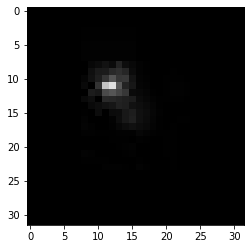

In [27]:
#Add classifier output to DataFrame for Binary examples
df_binaries['classifier'] = -1
df_binaries['usedfortraining'] = -1

files = os.listdir('./CNN_input/Test/Binary/')
for file in files:
    idnr = file.split('.')[0].split('_')[-1]
    print('./CNN_input/Test/Binary/'+file)
    label_predict = predictImage('./CNN_input/Test/Binary/'+file)
    print(idnr, label_predict)
    df_binaries.loc[int(idnr),'classifier'] = label_predict[0][0]
    df_binaries.loc[int(idnr),'usedfortraining'] = 0

files = os.listdir('./CNN_input/Train/Binary/')
for file in files:
    idnr = file.split('.')[0].split('_')[-1]
    label_predict = predictImage('./CNN_input/Train/Binary/'+file)
    print(idnr, label_predict)
    df_binaries.loc[int(idnr),'classifier'] = label_predict[0][0]
    df_binaries.loc[int(idnr),'usedfortraining'] = 1

[[0.03372389]]
0 [[0.03372389]]
[[0.07909858]]
1 [[0.07909858]]
[[0.02911425]]
2 [[0.02911425]]
[[0.03900951]]
3 [[0.03900951]]
[[0.65269715]]
4 [[0.65269715]]
[[0.01073712]]
5 [[0.01073712]]
[[0.03239593]]
6 [[0.03239593]]
[[0.1621921]]
7 [[0.1621921]]
[[1.3830108e-07]]
8 [[1.3830108e-07]]
[[0.08038929]]
9 [[0.08038929]]
[[0.29966635]]
10 [[0.29966635]]
[[0.16438025]]
11 [[0.16438025]]
[[0.00080806]]
12 [[0.00080806]]
[[0.08469784]]
13 [[0.08469784]]
[[0.12802032]]
14 [[0.12802032]]
[[0.0439921]]
15 [[0.0439921]]
[[0.29966635]]
16 [[0.29966635]]
[[0.05630177]]
17 [[0.05630177]]
[[0.0221476]]
18 [[0.0221476]]
[[0.10888124]]
19 [[0.10888124]]
[[0.12002018]]
20 [[0.12002018]]
[[0.04156294]]
21 [[0.04156294]]
[[0.11280543]]
22 [[0.11280543]]
[[0.048967]]
23 [[0.048967]]
[[0.15147]]
24 [[0.15147]]
[[0.1385974]]
25 [[0.1385974]]
[[0.01860568]]
26 [[0.01860568]]
[[0.10624477]]
27 [[0.10624477]]
[[0.29966635]]
28 [[0.29966635]]
[[0.09096196]]
29 [[0.09096196]]
[[0.04728734]]
30 [[0.04728734]]

[[0.31931582]]
245 [[0.31931582]]
[[0.02803639]]
246 [[0.02803639]]
[[0.04690981]]
247 [[0.04690981]]
[[0.0419127]]
248 [[0.0419127]]
[[0.29966635]]
249 [[0.29966635]]
[[0.29966635]]
250 [[0.29966635]]
[[0.02931744]]
251 [[0.02931744]]
[[0.02736583]]
252 [[0.02736583]]
[[0.07860759]]
253 [[0.07860759]]
[[0.29966635]]
254 [[0.29966635]]
[[0.0183199]]
255 [[0.0183199]]
[[0.01307812]]
256 [[0.01307812]]
[[0.07423618]]
257 [[0.07423618]]
[[0.13931537]]
258 [[0.13931537]]
[[0.16740227]]
259 [[0.16740227]]
[[0.02249715]]
260 [[0.02249715]]
[[0.07596609]]
261 [[0.07596609]]
[[1.3617296e-06]]
262 [[1.3617296e-06]]
[[0.04085705]]
263 [[0.04085705]]
[[0.06842434]]
264 [[0.06842434]]
[[0.02422681]]
265 [[0.02422681]]
[[0.04027018]]
266 [[0.04027018]]
[[0.03932884]]
267 [[0.03932884]]
[[0.02493191]]
268 [[0.02493191]]
[[0.09954965]]
269 [[0.09954965]]
[[0.14174828]]
270 [[0.14174828]]
[[7.523521e-05]]
271 [[7.523521e-05]]
[[0.6221309]]
272 [[0.6221309]]
[[0.06848574]]
273 [[0.06848574]]
[[0.130313

[[0.21298644]]
489 [[0.21298644]]
[[0.08844456]]
490 [[0.08844456]]
[[0.29966635]]
491 [[0.29966635]]
[[0.07261282]]
492 [[0.07261282]]
[[0.04699263]]
493 [[0.04699263]]
[[0.21133235]]
494 [[0.21133235]]
[[0.01910371]]
495 [[0.01910371]]
[[0.02980337]]
496 [[0.02980337]]
[[0.03997433]]
497 [[0.03997433]]
[[0.05855194]]
498 [[0.05855194]]
[[0.07268161]]
499 [[0.07268161]]
[[0.09776896]]
500 [[0.09776896]]
[[0.84417427]]
501 [[0.84417427]]
[[0.42903417]]
502 [[0.42903417]]
[[0.03298897]]
503 [[0.03298897]]
[[0.0532631]]
504 [[0.0532631]]
[[0.07613212]]
505 [[0.07613212]]
[[0.03790179]]
506 [[0.03790179]]
[[0.05216721]]
507 [[0.05216721]]
[[0.01634791]]
508 [[0.01634791]]
[[0.25608802]]
509 [[0.25608802]]
[[0.0132049]]
510 [[0.0132049]]
[[0.31659785]]
511 [[0.31659785]]
[[0.0193859]]
512 [[0.0193859]]
[[0.29966635]]
513 [[0.29966635]]
[[0.03144392]]
514 [[0.03144392]]
[[0.05532491]]
515 [[0.05532491]]
[[0.29966635]]
516 [[0.29966635]]
[[0.50610673]]
517 [[0.50610673]]
[[0.29966635]]
518 [

[[0.11685666]]
735 [[0.11685666]]
[[0.24495873]]
736 [[0.24495873]]
[[0.0688248]]
737 [[0.0688248]]
[[0.12008691]]
738 [[0.12008691]]
[[0.18104482]]
739 [[0.18104482]]
[[0.05899987]]
740 [[0.05899987]]
[[0.02267945]]
741 [[0.02267945]]
[[0.06010574]]
742 [[0.06010574]]
[[0.05878359]]
743 0 [[0.05878359]]
[[0.0117116]]
744 1 [[0.0117116]]
[[0.03372389]]
745 2 [[0.03372389]]
[[0.07356423]]
746 3 [[0.07356423]]
[[0.07047155]]
747 4 [[0.07047155]]
[[0.07909858]]
748 5 [[0.07909858]]
[[0.02911425]]
749 6 [[0.02911425]]
[[0.03900951]]
750 7 [[0.03900951]]
[[0.271413]]
751 8 [[0.271413]]
[[0.65269715]]
752 9 [[0.65269715]]
[[0.15495506]]
753 10 [[0.15495506]]
[[0.01073712]]
754 11 [[0.01073712]]
[[0.03239593]]
755 12 [[0.03239593]]
[[0.03532538]]
756 13 [[0.03532538]]
[[0.0830805]]
757 14 [[0.0830805]]
[[0.29966635]]
758 15 [[0.29966635]]
[[0.06346017]]
759 16 [[0.06346017]]
[[1.3830108e-07]]
760 17 [[1.3830108e-07]]
[[0.08038929]]
761 18 [[0.08038929]]
[[0.29966635]]
762 19 [[0.29966635]]
[[

[[2.942413e-10]]
956 213 [[2.942413e-10]]
[[0.11078095]]
957 214 [[0.11078095]]
[[0.14140305]]
958 215 [[0.14140305]]
[[0.0426082]]
959 216 [[0.0426082]]
[[0.03364658]]
960 217 [[0.03364658]]
[[0.29966635]]
961 218 [[0.29966635]]
[[0.86061233]]
962 219 [[0.86061233]]
[[0.06999451]]
963 220 [[0.06999451]]
[[0.07060686]]
964 221 [[0.07060686]]
[[0.06720322]]
965 222 [[0.06720322]]
[[0.07683873]]
966 223 [[0.07683873]]
[[0.17215937]]
967 224 [[0.17215937]]
[[0.04855841]]
968 225 [[0.04855841]]
[[0.02615303]]
969 226 [[0.02615303]]
[[0.09053516]]
970 227 [[0.09053516]]
[[0.20091477]]
971 228 [[0.20091477]]
[[0.07960671]]
972 229 [[0.07960671]]
[[0.02665311]]
973 230 [[0.02665311]]
[[0.02949828]]
974 231 [[0.02949828]]
[[0.19901955]]
975 232 [[0.19901955]]
[[0.03244269]]
976 233 [[0.03244269]]
[[0.0296056]]
977 234 [[0.0296056]]
[[0.1310704]]
978 235 [[0.1310704]]
[[1.2160704e-05]]
979 236 [[1.2160704e-05]]
[[0.17326555]]
980 237 [[0.17326555]]
[[0.01898351]]
981 238 [[0.01898351]]
[[0.0338

[[0.0427376]]
1168 425 [[0.0427376]]
[[0.29966635]]
1169 426 [[0.29966635]]
[[0.12796524]]
1170 427 [[0.12796524]]
[[0.08050683]]
1171 428 [[0.08050683]]
[[0.09834695]]
1172 429 [[0.09834695]]
[[0.12273306]]
1173 430 [[0.12273306]]
[[0.01173133]]
1174 431 [[0.01173133]]
[[0.10572305]]
1175 432 [[0.10572305]]
[[0.06620598]]
1176 433 [[0.06620598]]
[[0.06623268]]
1177 434 [[0.06623268]]
[[0.03780305]]
1178 435 [[0.03780305]]
[[0.09920552]]
1179 436 [[0.09920552]]
[[0.0255712]]
1180 437 [[0.0255712]]
[[0.02523634]]
1181 438 [[0.02523634]]
[[0.03242043]]
1182 439 [[0.03242043]]
[[0.04409578]]
1183 440 [[0.04409578]]
[[0.11628288]]
1184 441 [[0.11628288]]
[[0.11649671]]
1185 442 [[0.11649671]]
[[5.850217e-07]]
1186 443 [[5.850217e-07]]
[[0.05078933]]
1187 444 [[0.05078933]]
[[0.03619987]]
1188 445 [[0.03619987]]
[[0.05864036]]
1189 446 [[0.05864036]]
[[0.05178747]]
1190 447 [[0.05178747]]
[[0.06789979]]
1191 448 [[0.06789979]]
[[0.06168538]]
1192 449 [[0.06168538]]
[[0.09512198]]
1193 450 [

[[0.09229651]]
1381 638 [[0.09229651]]
[[0.19473243]]
1382 639 [[0.19473243]]
[[0.04839793]]
1383 640 [[0.04839793]]
[[0.08213201]]
1384 641 [[0.08213201]]
[[0.0165624]]
1385 642 [[0.0165624]]
[[0.15080974]]
1386 643 [[0.15080974]]
[[0.05927572]]
1387 644 [[0.05927572]]
[[0.07469252]]
1388 645 [[0.07469252]]
[[0.05679137]]
1389 646 [[0.05679137]]
[[0.11077356]]
1390 647 [[0.11077356]]
[[0.22161353]]
1391 648 [[0.22161353]]
[[0.06499454]]
1392 649 [[0.06499454]]
[[0.26752907]]
1393 650 [[0.26752907]]
[[0.07054266]]
1394 651 [[0.07054266]]
[[0.06958187]]
1395 652 [[0.06958187]]
[[0.02824423]]
1396 653 [[0.02824423]]
[[0.12632558]]
1397 654 [[0.12632558]]
[[0.080073]]
1398 655 [[0.080073]]
[[0.07152912]]
1399 656 [[0.07152912]]
[[0.00507215]]
1400 657 [[0.00507215]]
[[0.08258495]]
1401 658 [[0.08258495]]
[[1.24122e-06]]
1402 659 [[1.24122e-06]]
[[0.06459835]]
1403 660 [[0.06459835]]
[[0.32609528]]
1404 661 [[0.32609528]]
[[0.0472227]]
1405 662 [[0.0472227]]
[[0.06025276]]
1406 663 [[0.060

[[0.25885636]]
1592 849 [[0.25885636]]
[[0.06253493]]
1593 850 [[0.06253493]]
[[4.7905237e-06]]
1594 851 [[4.7905237e-06]]
[[0.03189859]]
1595 852 [[0.03189859]]
[[0.1389111]]
1596 853 [[0.1389111]]
[[0.24912155]]
1597 854 [[0.24912155]]
[[0.21201846]]
1598 855 [[0.21201846]]
[[0.04563063]]
1599 856 [[0.04563063]]
[[0.05649358]]
1600 857 [[0.05649358]]
[[0.02019238]]
1601 858 [[0.02019238]]
[[0.15757856]]
1602 859 [[0.15757856]]
[[6.856551e-07]]
1603 860 [[6.856551e-07]]
[[0.02515465]]
1604 861 [[0.02515465]]
[[0.00909245]]
1605 862 [[0.00909245]]
[[0.0001592]]
1606 863 [[0.0001592]]
[[0.16371736]]
1607 864 [[0.16371736]]
[[0.15496516]]
1608 865 [[0.15496516]]
[[0.15550801]]
1609 866 [[0.15550801]]
[[0.03084809]]
1610 867 [[0.03084809]]
[[0.22865656]]
1611 868 [[0.22865656]]
[[0.17968744]]
1612 869 [[0.17968744]]
[[0.17927757]]
1613 870 [[0.17927757]]
[[0.12496129]]
1614 871 [[0.12496129]]
[[0.14345142]]
1615 872 [[0.14345142]]
[[0.152482]]
1616 873 [[0.152482]]
[[0.05334783]]
1617 874

[[0.03170341]]
1807 1064 [[0.03170341]]
[[0.02266476]]
1808 1065 [[0.02266476]]
[[0.33230215]]
1809 1066 [[0.33230215]]
[[0.01273263]]
1810 1067 [[0.01273263]]
[[0.15363526]]
1811 1068 [[0.15363526]]
[[1.6538374e-06]]
1812 1069 [[1.6538374e-06]]
[[0.07536224]]
1813 1070 [[0.07536224]]
[[0.07081869]]
1814 1071 [[0.07081869]]
[[0.29966635]]
1815 1072 [[0.29966635]]
[[0.12296206]]
1816 1073 [[0.12296206]]
[[4.890905e-06]]
1817 1074 [[4.890905e-06]]
[[0.05264878]]
1818 1075 [[0.05264878]]
[[0.05830821]]
1819 1076 [[0.05830821]]
[[0.03107727]]
1820 1077 [[0.03107727]]
[[0.08142689]]
1821 1078 [[0.08142689]]
[[0.20082968]]
1822 1079 [[0.20082968]]
[[0.04954043]]
1823 1080 [[0.04954043]]
[[7.3437004e-06]]
1824 1081 [[7.3437004e-06]]
[[0.29966635]]
1825 1082 [[0.29966635]]
[[0.07821473]]
1826 1083 [[0.07821473]]
[[0.13671687]]
1827 1084 [[0.13671687]]
[[0.02537003]]
1828 1085 [[0.02537003]]
[[0.02707115]]
1829 1086 [[0.02707115]]
[[0.16812944]]
1830 1087 [[0.16812944]]
[[0.0225825]]
1831 1088 

[[3.766208e-08]]
2013 1270 [[3.766208e-08]]
[[0.16112652]]
2014 1271 [[0.16112652]]
[[0.8288374]]
2015 1272 [[0.8288374]]
[[0.141967]]
2016 1273 [[0.141967]]
[[0.0461719]]
2017 1274 [[0.0461719]]
[[0.05648828]]
2018 1275 [[0.05648828]]
[[0.13981852]]
2019 1276 [[0.13981852]]
[[0.03961137]]
2020 1277 [[0.03961137]]
[[0.03017741]]
2021 1278 [[0.03017741]]
[[1.834281e-05]]
2022 1279 [[1.834281e-05]]
[[0.01884767]]
2023 1280 [[0.01884767]]
[[0.01278612]]
2024 1281 [[0.01278612]]
[[0.16022417]]
2025 1282 [[0.16022417]]
[[0.12337175]]
2026 1283 [[0.12337175]]
[[0.15604258]]
2027 1284 [[0.15604258]]
[[0.03121781]]
2028 1285 [[0.03121781]]
[[0.05439097]]
2029 1286 [[0.05439097]]
[[0.03660247]]
2030 1287 [[0.03660247]]
[[0.0924339]]
2031 1288 [[0.0924339]]
[[0.02938935]]
2032 1289 [[0.02938935]]
[[0.02339515]]
2033 1290 [[0.02339515]]
[[0.12569588]]
2034 1291 [[0.12569588]]
[[0.10736242]]
2035 1292 [[0.10736242]]
[[0.09224793]]
2036 1293 [[0.09224793]]
[[0.03403687]]
2037 1294 [[0.03403687]]
[[

[[0.21028757]]
2219 1476 [[0.21028757]]
[[0.1133509]]
2220 1477 [[0.1133509]]
[[0.29966635]]
2221 1478 [[0.29966635]]
[[0.03503594]]
2222 1479 [[0.03503594]]
[[0.06522337]]
2223 1480 [[0.06522337]]
[[0.12439612]]
2224 1481 [[0.12439612]]
[[0.29966635]]
2225 1482 [[0.29966635]]
[[0.23125693]]
2226 1483 [[0.23125693]]
[[0.20193389]]
2227 1484 [[0.20193389]]
[[0.25994733]]
2228 1485 [[0.25994733]]
[[0.08886099]]
2229 1486 [[0.08886099]]
[[0.09601122]]
2230 1487 [[0.09601122]]
[[0.10397464]]
2231 1488 [[0.10397464]]
[[0.05780983]]
2232 1489 [[0.05780983]]
[[0.05762407]]
2233 1490 [[0.05762407]]
[[0.04469103]]
2234 1491 [[0.04469103]]
[[0.05183798]]
2235 1492 [[0.05183798]]
[[0.0490669]]
2236 1493 [[0.0490669]]
[[0.1573951]]
2237 1494 [[0.1573951]]
[[0.03374824]]
2238 1495 [[0.03374824]]
[[9.876362e-07]]
2239 1496 [[9.876362e-07]]
[[0.09202087]]
2240 1497 [[0.09202087]]
[[0.11685666]]
2241 1498 [[0.11685666]]
[[0.24495873]]
2242 1499 [[0.24495873]]
[[0.03507388]]
2243 1500 [[0.03507388]]
[[

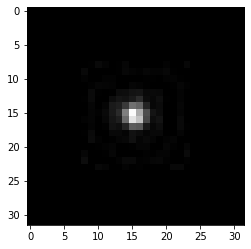

In [28]:
#Make a DataFrame with all Single examples
df_singles = pd.DataFrame(data={}, columns=['classifier','usedfortraining'])
files = os.listdir('./CNN_input/Test/Single/')
for i, file in enumerate(files):
    label_predict = predictImage('./CNN_input/Test/Single/'+file)
    print(i, label_predict)
    df_singles.loc[i,'classifier'] = label_predict[0][0]
    df_singles.loc[i,'usedfortraining'] = 0
ntest = i+1

files = os.listdir('./CNN_input/Train/Single/')
for i, file in enumerate(files):
    label_predict = predictImage('./CNN_input/Train/Single/'+file)
    print(i+ntest, i, label_predict)
    df_singles.loc[i+ntest,'classifier'] = label_predict[0][0]
    df_singles.loc[i+ntest,'usedfortraining'] = 1

In [29]:
#Only use examples that were not used for Training
df_singles['label'] = 0
df_binaries['label'] = 1
SELSINGLES = df_singles['usedfortraining'] < 0.5
SELBINARIES = df_binaries['usedfortraining'] < 0.5
LABELS = np.concatenate((df_singles[SELSINGLES]['label'].to_numpy(),df_binaries[SELBINARIES]['label'].to_numpy()))
CLASSIFIER = np.concatenate((df_singles[SELSINGLES]['classifier'].to_numpy(),df_binaries[SELBINARIES]['classifier'].to_numpy()))


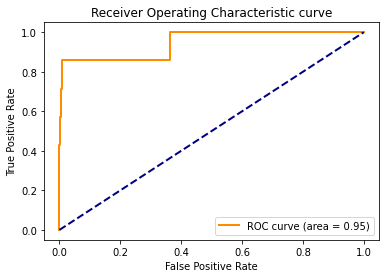

In [30]:
#Evaluate performance
fpr, tpr, _ = roc_curve(LABELS,CLASSIFIER)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

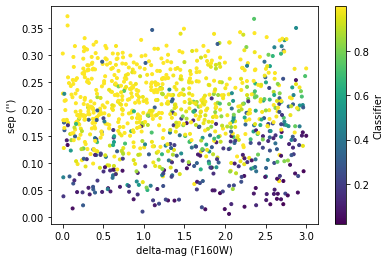

In [31]:
#As expected, performance is best for stars that are well separated and have large brightness ratios
SEL = df_binaries['usedfortraining'] < 2.5
plt.scatter(abs(df_binaries[SEL]['mag1']-df_binaries[SEL]['mag2']), 0.06*df_binaries[SEL]['seppix'], marker='.',c=df_binaries[SEL]['classifier'])
plt.colorbar(label='Classifier')
plt.xlabel('delta-mag (F160W)')
plt.ylabel("sep ('')")
plt.show()